#  INIT

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/cytof_data/')
sys.path.append('../experiments/')
sys.path.append('../infras/dashboards')

from cellMix_coordinator import CellMixCoordinator

import exploration_plots
import dashs

In [3]:
import exploration_cytof_plots as cytof_plots
from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments

ccc= CytofCellCountInfra()

In [4]:
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing

from itertools import chain
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

from scipy.stats import entropy
from functools import reduce
import matplotlib.patches as patches


import os

In [5]:
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins

from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader

from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation

from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot

# from deconv_py.infras.cellMix.cellMix_coordinator import CellMixCoordinator

In [6]:
data_loader = DataLoader(mass_spec_path=os.path.abspath('../data/20190801_filtered_imputed_data.csv'),
                         protein_profile_path = os.path.abspath('../data/20150718_Cerberus_proteinGroups.txt'),as_csv = True)
data_factory = DataFactory(data_loader)
ms = data_loader.get_mass_spec_data()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## build A/B_all_vs  - finding low intra var genes

In [7]:
def get_gene_to_var(profile):
    gene_to_intra_var_profile_data = profile.copy(deep=True).T
    gene_to_intra_var_profile_data["cell"]=gene_to_intra_var_profile_data.index.map(lambda x:x.split('_0')[0])
    gene_to_intra_var_profile_data = (gene_to_intra_var_profile_data.groupby("cell").std()/(gene_to_intra_var_profile_data.groupby("cell").mean()+0.001)).T
    gene_to_inter_var_profile_data =  profile.T.std() /(profile.T.mean()+0.001)

    gene_to_var = gene_to_intra_var_profile_data
    gene_to_var["inter"] = gene_to_inter_var_profile_data

    return gene_to_var[~gene_to_var["inter"].isna()]

In [8]:
relvent_data_intensity = data_factory._build_relvent_data( DataFactory.IBD_A_RELVENT_DATA_all_vs,"Intensity")
profile_data_intensity,profile_data_relvent_data_intensity = data_factory.build_cell_specific_profile(auto_filter_by=False,relvent_data=relvent_data_intensity,relvent_columns=["Majority protein IDs","Gene names"])
mixtures,mixtures_relvent_data = data_factory.build_mixture_data(relvent_data= ms.columns.tolist() ,relvent_columns=["Majority protein IDs","Gene.names"],auto_filter_by=False,log2_transformation=True)

In [9]:
protein_gene_map = profile_data_intensity[["Majority protein IDs","Gene names"]].set_index("Majority protein IDs").to_dict()['Gene names']

In [10]:
index_func = lambda x:x
_profile_data_intensity,_mixtures = PP_base.return_mutual_proteins_by_index(profile_data_intensity,mixtures,index_func=index_func)
A_all_vs = _profile_data_intensity[profile_data_relvent_data_intensity].copy(deep=True)
B_all_vs = _mixtures[mixtures_relvent_data].copy(deep=True)

In [11]:
A_intensity = A_all_vs.copy(deep=True)[[col for col in A_all_vs.columns if "01" in col]]
B = B_all_vs[[col for col in B_all_vs.columns if "v1" in col]]

A_intensity,B = PP_proteins.pp_clean_irrelevant_proteins(A_intensity,B)

In [12]:
A_all_vs = A_all_vs.merge(_profile_data_intensity["Gene names"].to_frame(),left_index=True,right_index=True).set_index(["Gene names"],append=True)

In [13]:
_gene_to_var = get_gene_to_var(A_all_vs)

In [14]:
cell_to_solid_proteins = {}
cell_to_solid_genes = {}

all_solid_proteins = []
all_solid_genes = []

for cell_name in _gene_to_var:
    if cell_name == "inter" :
        continue
    
    cell_var = _gene_to_var[cell_name]
    cell_var = cell_var.dropna()
    cell_var = cell_var[cell_var < 0.5]
    
    protein_list = cell_var.index.get_level_values("major_protein_id").tolist()
    gene_list = cell_var.index.get_level_values("Gene names").tolist()
    
    cell_to_solid_proteins[cell_name] =  protein_list
    all_solid_proteins = all_solid_proteins + protein_list
    
    cell_to_solid_genes[cell_name] = gene_list
    all_solid_genes = all_solid_genes + gene_list
    
union_solid_proteins=list(set(all_solid_proteins))
union_solid_genes=list(set(all_solid_genes))[1:]

In [15]:
_gene_to_var_no_inter = _gene_to_var.drop(columns="inter")
all_solid_genes = _gene_to_var_no_inter[_gene_to_var_no_inter < 1].dropna().index.get_level_values(level=1)[1:].dropna()
all_solid_proteins = _gene_to_var_no_inter[_gene_to_var_no_inter < 1].dropna().index.get_level_values(level=0)

In [16]:
A_intensity = A_intensity.loc[all_solid_proteins].dropna()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


## read data - intensities

### mixture & cell specific data

**LFQ:** rel. quantification – for same protein across different samples

**iBAQ:** orthogonal comparison – for different proteins in the same sample

In [17]:
relvent_data_iBAQ = data_factory._build_relvent_data( DataFactory.IBD_A_RELVENT_DATA,"iBAQ")
profile_data_iBAQ,profile_data_relvent_data_iBAQ = data_factory.build_cell_specific_profile(auto_filter_by=False,relvent_data=relvent_data_iBAQ,relvent_columns=["Majority protein IDs","Gene names"])
mixtures,mixtures_relvent_data = data_factory.build_mixture_data(relvent_data= ms.columns.tolist() ,relvent_columns=["Majority protein IDs","Gene.names"],auto_filter_by=False,log2_transformation=True)

## build A ,X and B 

In [18]:
index_func = lambda x:x
_profile_data_iBAQ,_mixtures = PP_base.return_mutual_proteins_by_index(profile_data_iBAQ,mixtures,index_func=index_func)
A_iBAQ = _profile_data_iBAQ[profile_data_relvent_data_iBAQ]
B = _mixtures[mixtures_relvent_data]
# X = cell_proportions_df

In [19]:
# B=B.rename({f:f.split('Intensity ')[1] for f in B.columns},axis=1)

# X = X.rename({f:f.split('Intensity ')[1] for f in X.index},axis=0)
# X = X.rename({f:'mixture'+str(f) for f in X.columns},axis=1)

A_iBAQ = A_iBAQ.rename({f:f.split('iBAQ ')[1] for f in A_iBAQ.columns},axis=1)

# Comparisons

## human proteins atlas 

**Transcript expression levels summarized per gene in 18 blood cell types and total PBMC** 


**protein-coding transcripts per million ("pTPM"):** 
fraction of transcripts per million of total transcripts from protein-coding genes - The pTPM values can be used to investigate the abundance of a particular gene, gene family, or gene class relative to all other transcripts in a particular cell, tissue, or organ. 

**normalized expression ("NX"):**
The objective of using the NX value is to facilitate the
analysis of differences in expression of genes
between cells, tissues, and organs and to allow for a specificity classification based on the
genome-wide expression of all genes across the
human blood cells, tissues, and organs.

***The data is based on The Human Protein Atlas version 19.1 and Ensembl version 92.38.


In [20]:
rna_blood_cell_df = pd.read_csv("../data/gene_expression/human atlas/rna_blood_cell.tsv",sep="\t")
rna_blood_cell_df =rna_blood_cell_df.loc[~rna_blood_cell_df[["Gene name","Blood cell"]].duplicated()]
ptmp_rna_cell_df = rna_blood_cell_df.pivot(index = "Gene name",columns="Blood cell",values="pTPM")
nx_rna_cell_df = rna_blood_cell_df.pivot(index = "Gene name",columns="Blood cell",values="NX")


In [21]:
iBAQ_profile = profile_data_iBAQ[["Gene names"] + profile_data_relvent_data_iBAQ].set_index("Gene names")
iBAQ_profile = iBAQ_profile.loc[all_solid_genes]

In [22]:
mass_cell_to_gene_cell_map = {'NOT_BCellmemory_01': 'memory B-cell',
                                  'NOT_BCellnaive_01' : 'naive B-cell',
                                  'NOT_BCellplasma_01' : None,
                                  'NOT_CD4TCellmTregs_01' : 'T-reg',
                                  'NOT_CD4TCellnaive_01':'naive CD4 T-cell',
                                  'NOT_CD4TCellnTregs_01':'T-reg',
                                  'NOT_CD4TCellTcm_01' : 'memory CD4 T-cell' ,
                                  'NOT_CD4TCellTem_01' : None,
                                  'NOT_CD4TCellTemra_01' :None,
                                  'NOT_CD4TCellTh1_01':None,
                                  'NOT_CD4TCellTh17_01':None,
                                  'NOT_CD4TCellTh2_01':None,
                                  'NOT_CD8TCellnaive_01':'naive CD8 T-cell',
                                  'NOT_CD8TCellTcm_01' : 'memory CD8 T-cell',
                                  'NOT_CD8TCellTem_01' : None ,
                                  'NOT_CD8TCellTemra_01' : None,
                                  'NOT_DendriticCD1c_01' : None,
                                  'NOT_DendriticCD304_01' : None,
                                  'NOT_Erythrocytes_01' : None,
                                  'NOT_Monocytesclassical_01': 'classical monocyte' ,
                                  'NOT_Monocytesintermediate_01' : 'intermediate monocyte',
                                  'NOT_Monocytesnonclassical_01': 'non-classical monocyte',
                                  'NOT_NKCellsCD56bright_01' : 'NK-cell',
                                  'NOT_NKCellsCD56dim_01': 'NK-cell',
                                  'NOT_Thrombocytes_01' : None,
                                  'NOT_Granulocyteseosinophils_01' : "eosinophil",
                                  'NOT_GranulocytesBasophil_01' : "basophil"}
mass_cell_to_gene_cell_map = {('iBAQ '+k):v for k,v in mass_cell_to_gene_cell_map.items()}

def return_corosponding_profiles(home_profile,out_profile,mass_cell_to_gene_cell_map) : 
    def get_home_cor_gene(out_gene,mut_genes_multiple,mut_genes):
        if out_gene in mut_genes : 
            return out_gene
        if out_gene in mut_genes_multiple.keys():
            return mut_genes_multiple[out_gene]

    out_genes = nx_rna_cell_df.index.dropna().drop_duplicates()
    home_genes = home_profile.index.dropna().drop_duplicates()

    home_genes_multiple = [genes for genes in home_genes if ";" in genes] 
    mut_genes_multiple = {}
    for out_gene in out_genes : 
        for home_gene in home_genes_multiple:
            if out_gene in home_gene:
                mut_genes_multiple[out_gene] = home_gene

    mut_genes = out_genes.intersection(home_genes)
    
    filt_out_profile = out_profile.copy(deep=True).loc[mut_genes.union(pd.Index(mut_genes_multiple.keys()))]
    filt_out_profile["home_cor_gene"] = filt_out_profile.index.map(lambda out_gene:get_home_cor_gene(out_gene,mut_genes_multiple,mut_genes))
    #mean the duplicates : 
    filt_out_profile = filt_out_profile.groupby("home_cor_gene").mean()
    filt_home_profile = home_profile.loc[filt_out_profile.index]
    
    only_mut_cells_home_profile = filt_home_profile.rename(columns = mass_cell_to_gene_cell_map)[[col for col in mass_cell_to_gene_cell_map.values() if col is not 'None']]
    only_mut_cells_home_profile = only_mut_cells_home_profile.groupby(lambda x:x,axis=1).sum()
    only_mut_cells_out_df = filt_out_profile[only_mut_cells_home_profile.columns]
    return  only_mut_cells_home_profile,only_mut_cells_out_df

filt_iBAQ_profile,filt_ptmp_rna_cell_df = return_corosponding_profiles(iBAQ_profile,ptmp_rna_cell_df,mass_cell_to_gene_cell_map)

### all atlas

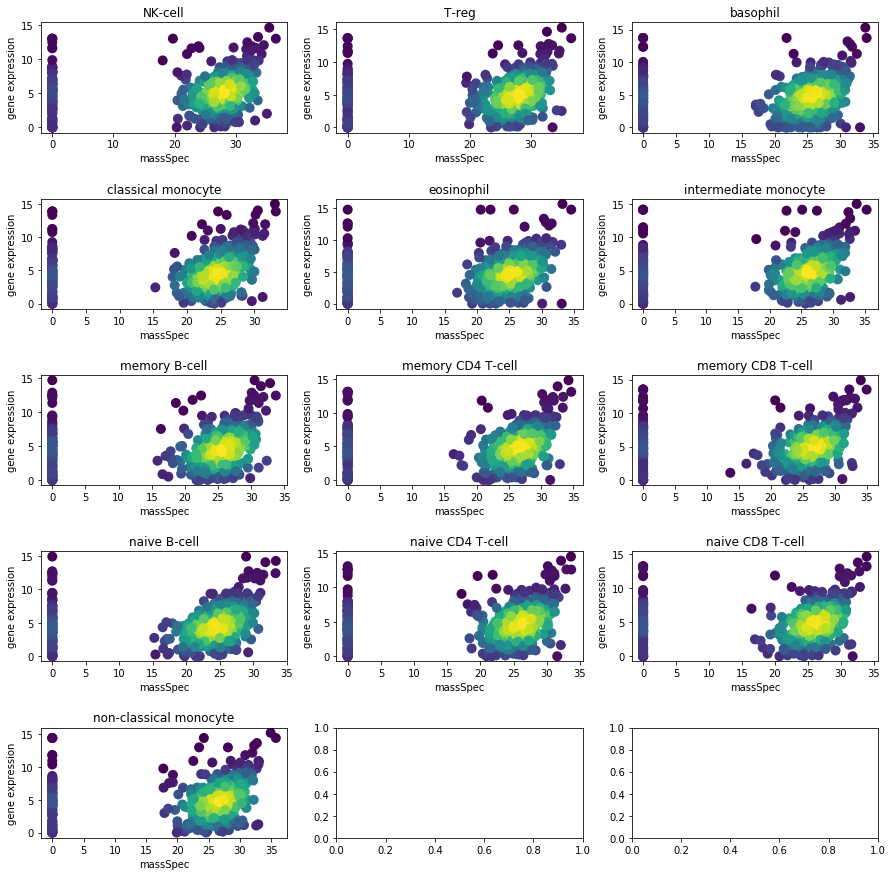

In [23]:
def plot_results(mass_profile,gene_profile):
    results = {}
    for _cell in mass_profile.columns : 
        if _cell in gene_profile.columns:
            merged_df = mass_profile[_cell].to_frame().merge(gene_profile[_cell].to_frame(),left_index = True,right_index = True)
            merged_df = merged_df.dropna(how="any")
            cell_name =_cell
            results[cell_name] = merged_df

    fig,axs = plt.subplots(int(np.ceil(len(results)/3)),3,figsize=(15,15))

    for (cell_name,df),ax in zip(results.items(),axs.reshape(-1)) : 
        x = np.log2(1+ df[df.columns[0]])
        y = np.log2(1 + df[df.columns[1]])

        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        ax.scatter(x, y, c=z,s=100, edgecolor='')
        ax.set_title(f"{cell_name}")
        ax.set_xlabel("massSpec")
        ax.set_ylabel("gene expression")
    plt.subplots_adjust(hspace = 0.6)

plot_results(filt_iBAQ_profile,filt_ptmp_rna_cell_df)

### signature - !!! this is comment out because the signature and the map are calculated only later !!! 

In [24]:
# signature_filt_iBAQ_profile = filt_iBAQ_profile.loc[long_possible_protein_list.map(lambda protein :protein_gene_map[protein]).dropna()]
# signature_filt_ptmp_rna_cell_df=filt_ptmp_rna_cell_df.loc[long_possible_protein_list.map(lambda protein :protein_gene_map[protein]).dropna()]
# # plot_results(signature_filt_iBAQ_profile,signature_filt_ptmp_rna_cell_df)

# Jan data cross MRna variability

In [25]:
def plot_inter_intra_cell_scatter(gene_to_var,gene_list = None,protein_list = None):
    fig, axs = plt.subplots(14,2,figsize=(15,45))
    
    if gene_list is not None : 
        gene_to_var = gene_to_var[gene_to_var.index.get_level_values("Gene names").isin(gene_list)]
    
    if protein_list is not None : 
        gene_to_var = gene_to_var[gene_to_var.index.get_level_values("major_protein_id").isin(protein_list)]
        
    for cell,ax in zip(gene_to_var.columns,axs.reshape(-1)) : 
        if cell == "inter" : 
            continue

        single_gene = gene_to_var[[cell,"inter"]].dropna()

        x = single_gene[single_gene.columns[0]]
        y = single_gene["inter"]
        
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        ax.scatter(x, y, c=z,s=100, edgecolor='')
        ax.set_title(cell)
        ax.set_xlabel("intra cell")
        ax.set_ylabel("inter cell")
        ax.set_xlim([-0.1,2.1])
        ax.set_ylim([-1,15])
    plt.subplots_adjust(hspace=0.5)  

In [26]:
A_all_vs = A_all_vs.loc[A_all_vs.index.get_level_values("Gene names").isin(all_solid_genes)]

In [27]:
gene_to_var = get_gene_to_var(A_all_vs)

## variability over protein signature

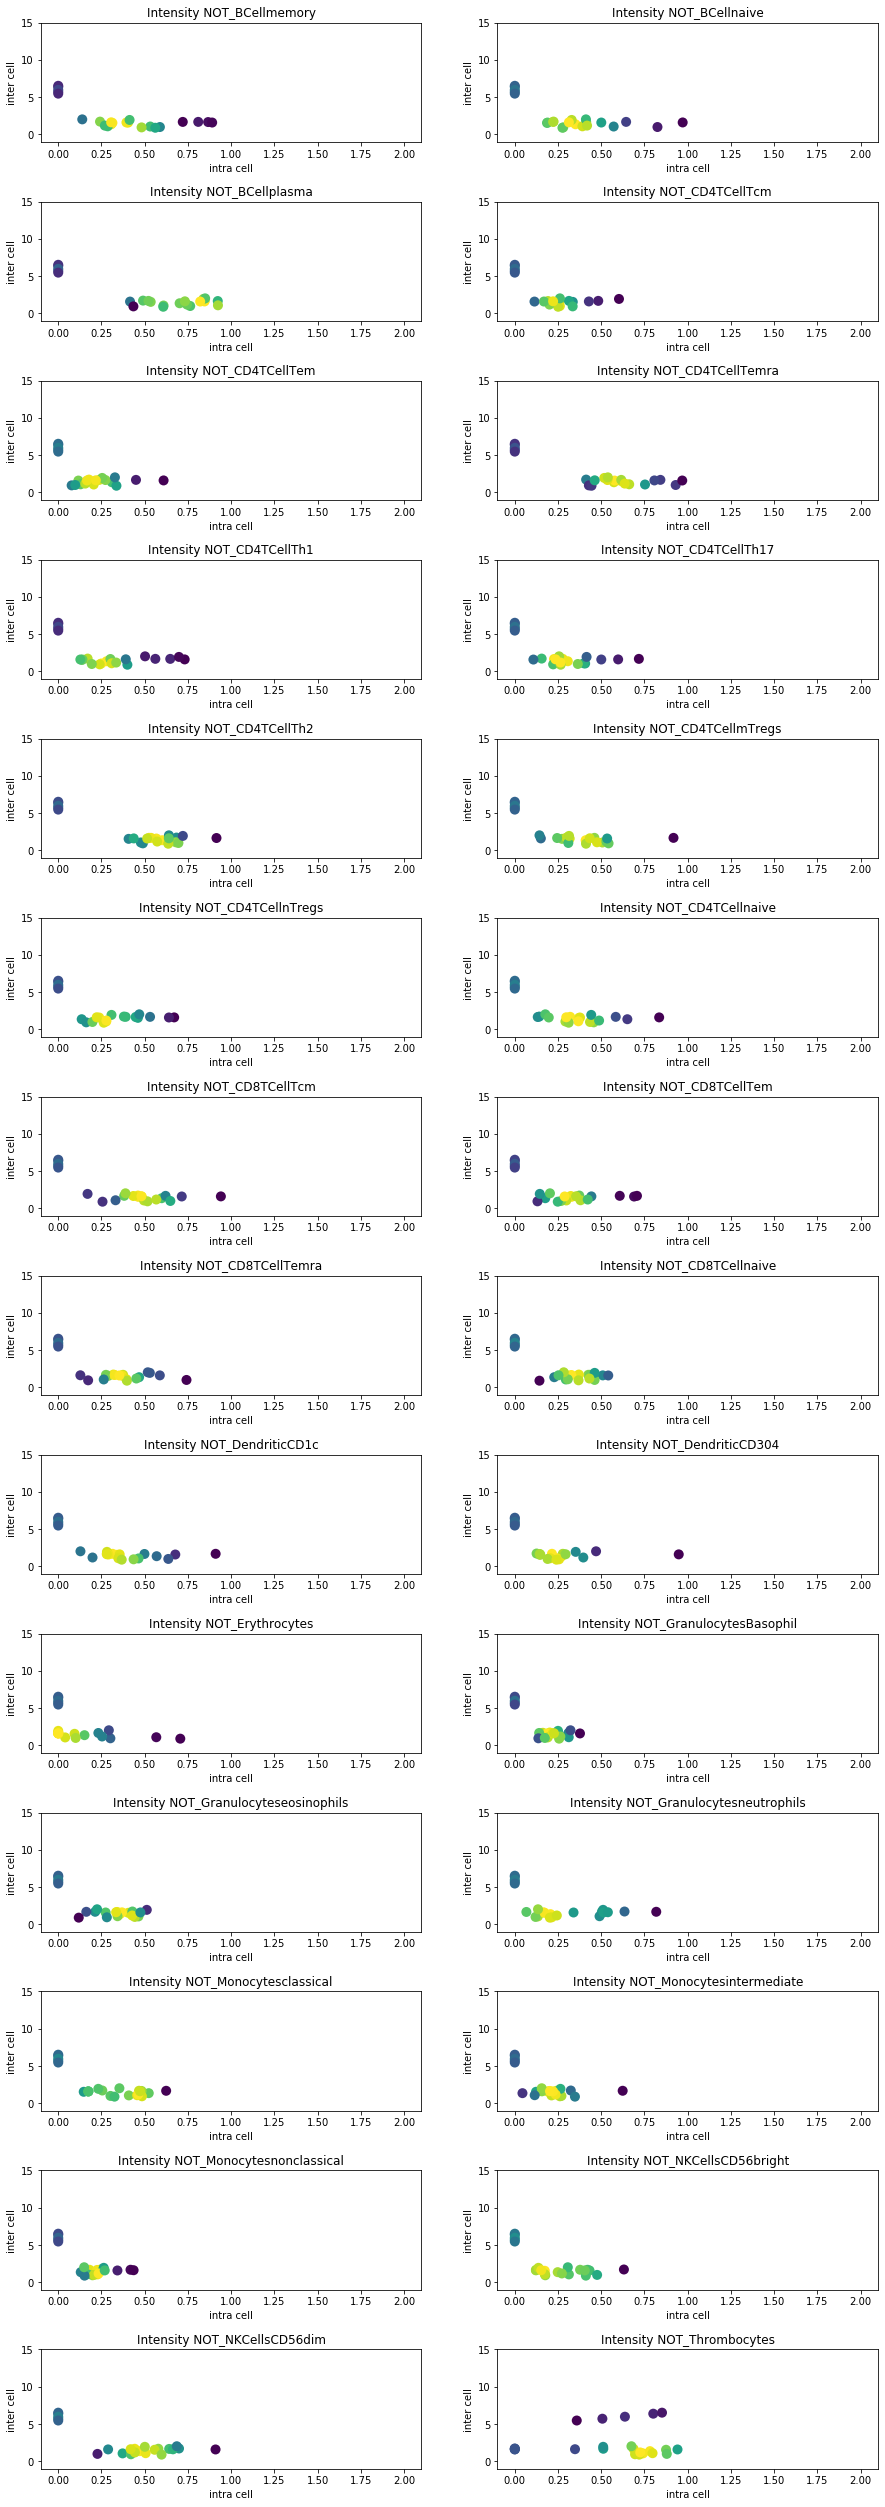

In [28]:
long_possible_protein_list=PP_proteins.pp_entropy_based(A_intensity,B,n_genes_per_cell=10,only_signature=True)
plot_inter_intra_cell_scatter(gene_to_var.copy(deep=True),protein_list =long_possible_protein_list)

## variability over Mrna signature

In [29]:
# get mutual genes with human atlas
intensity_profile = profile_data_intensity[["Gene names"] + profile_data_relvent_data_intensity].set_index("Gene names")
intensity_profile = intensity_profile.loc[all_solid_genes]

mass_cell_to_gene_cell_map = {'NOT_BCellmemory_01': 'memory B-cell',
                                  'NOT_BCellnaive_01' : 'naive B-cell',
                                  'NOT_BCellplasma_01' : None,
                                  'NOT_CD4TCellmTregs_01' : 'T-reg',
                                  'NOT_CD4TCellnaive_01':'naive CD4 T-cell',
                                  'NOT_CD4TCellnTregs_01':'T-reg',
                                  'NOT_CD4TCellTcm_01' : 'memory CD4 T-cell' ,
                                  'NOT_CD4TCellTem_01' : None,
                                  'NOT_CD4TCellTemra_01' :None,
                                  'NOT_CD4TCellTh1_01':None,
                                  'NOT_CD4TCellTh17_01':None,
                                  'NOT_CD4TCellTh2_01':None,
                                  'NOT_CD8TCellnaive_01':'naive CD8 T-cell',
                                  'NOT_CD8TCellTcm_01' : 'memory CD8 T-cell',
                                  'NOT_CD8TCellTem_01' : None ,
                                  'NOT_CD8TCellTemra_01' : None,
                                  'NOT_DendriticCD1c_01' : None,
                                  'NOT_DendriticCD304_01' : None,
                                  'NOT_Erythrocytes_01' : None,
                                  'NOT_Monocytesclassical_01': 'classical monocyte' ,
                                  'NOT_Monocytesintermediate_01' : 'intermediate monocyte',
                                  'NOT_Monocytesnonclassical_01': 'non-classical monocyte',
                                  'NOT_NKCellsCD56bright_01' : 'NK-cell',
                                  'NOT_NKCellsCD56dim_01': 'NK-cell',
                                  'NOT_Thrombocytes_01' : None,
                                  'NOT_Granulocyteseosinophils_01' : "eosinophil",
                                  'NOT_GranulocytesBasophil_01' : "basophil"}
mass_cell_to_gene_cell_map = {('Intensity '+k):v for k,v in mass_cell_to_gene_cell_map.items()}

filt_intensity_profile,filt_nx_rna_cell_df = return_corosponding_profiles(intensity_profile,nx_rna_cell_df,mass_cell_to_gene_cell_map)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\deconv_py\preprocess\cell_specific.py:150: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  cell_relvent_gene_entropy = cell_relvent_gene_entropy.loc[cell_to_list_of_max_genes[cell]].dropna()


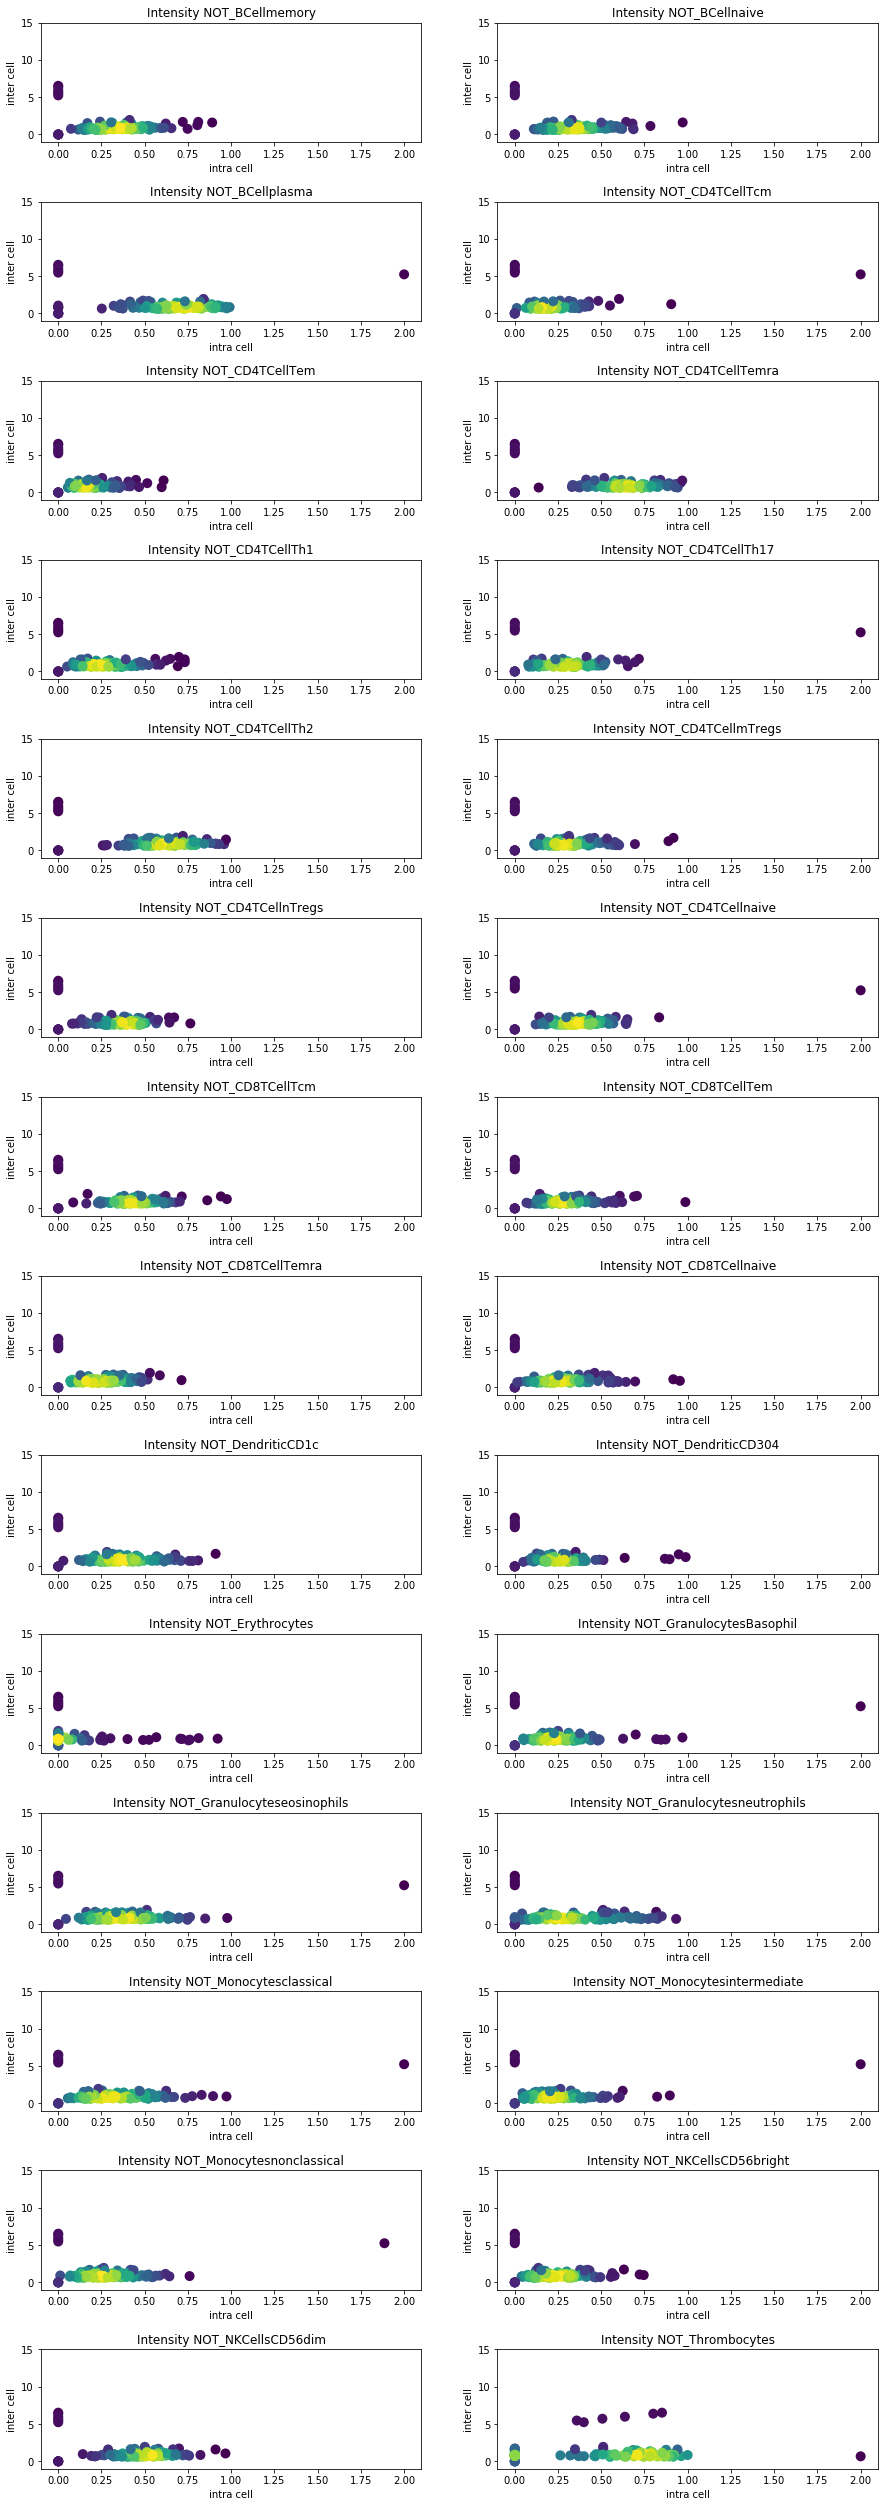

In [30]:
#we need to take from the HA only the ones that should pass "pp_clean_irrelevant_proteins"
clean_genes_from_B_index =  B.index.map(lambda protein:protein_gene_map[protein]).dropna()
clean_filt_nx_rna_cell_df = filt_nx_rna_cell_df.loc[clean_genes_from_B_index].dropna().drop_duplicates()

long_possible_gene_list_from_HA=PP_proteins.pp_entropy_largest_among_cells(clean_filt_nx_rna_cell_df,B,n_genes_per_cell=10,only_signature=True)
plot_inter_intra_cell_scatter(gene_to_var.copy(deep=True),gene_list=long_possible_gene_list_from_HA)

## mutual protein and Mrna

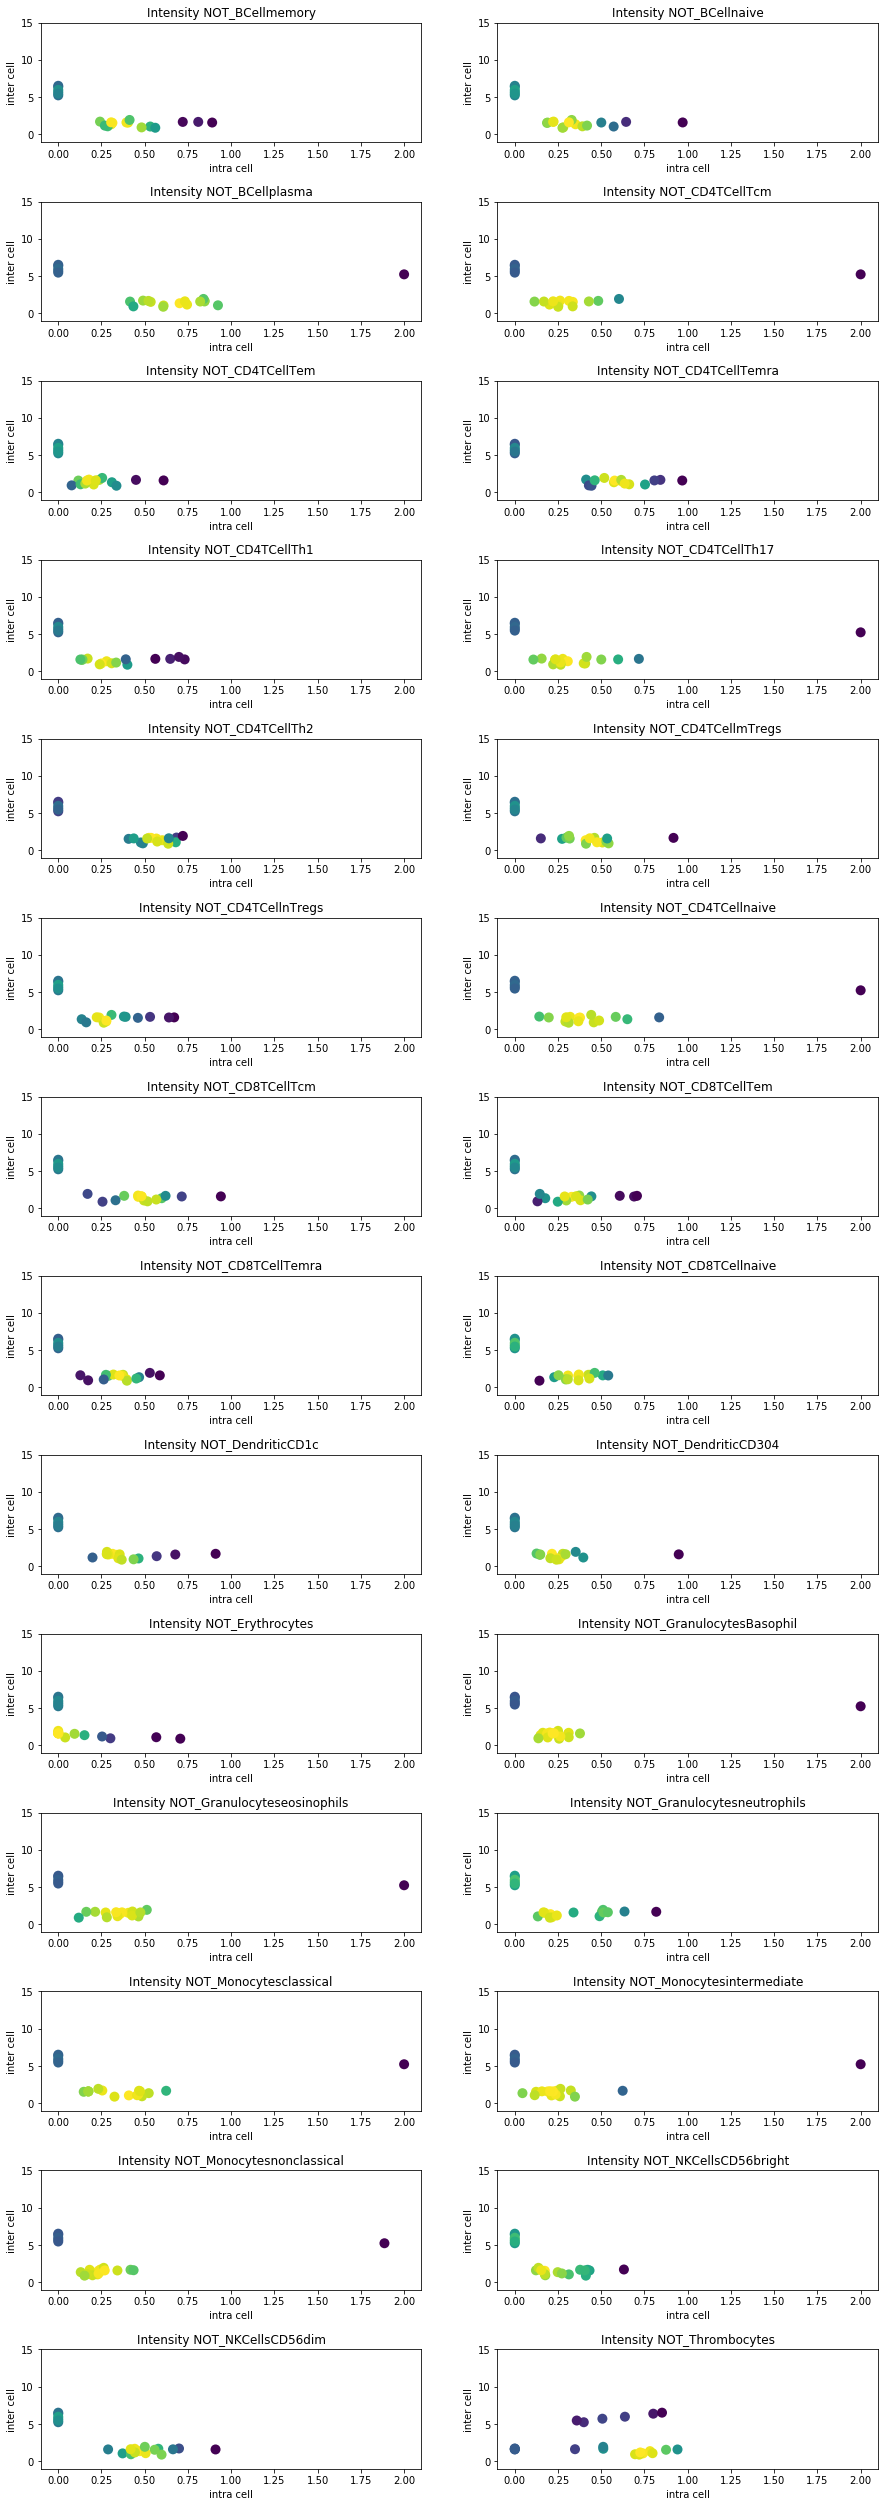

In [31]:
mutual_genes_mass_mrna = long_possible_protein_list.map(lambda protein : protein_gene_map[protein]).intersection(long_possible_gene_list_from_HA)
plot_inter_intra_cell_scatter(gene_to_var.copy(deep=True),gene_list=mutual_genes_mass_mrna)

# inter-cell variability proteins vs genes

C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


AttributeError: 'Series' object has no attribute 'columns'

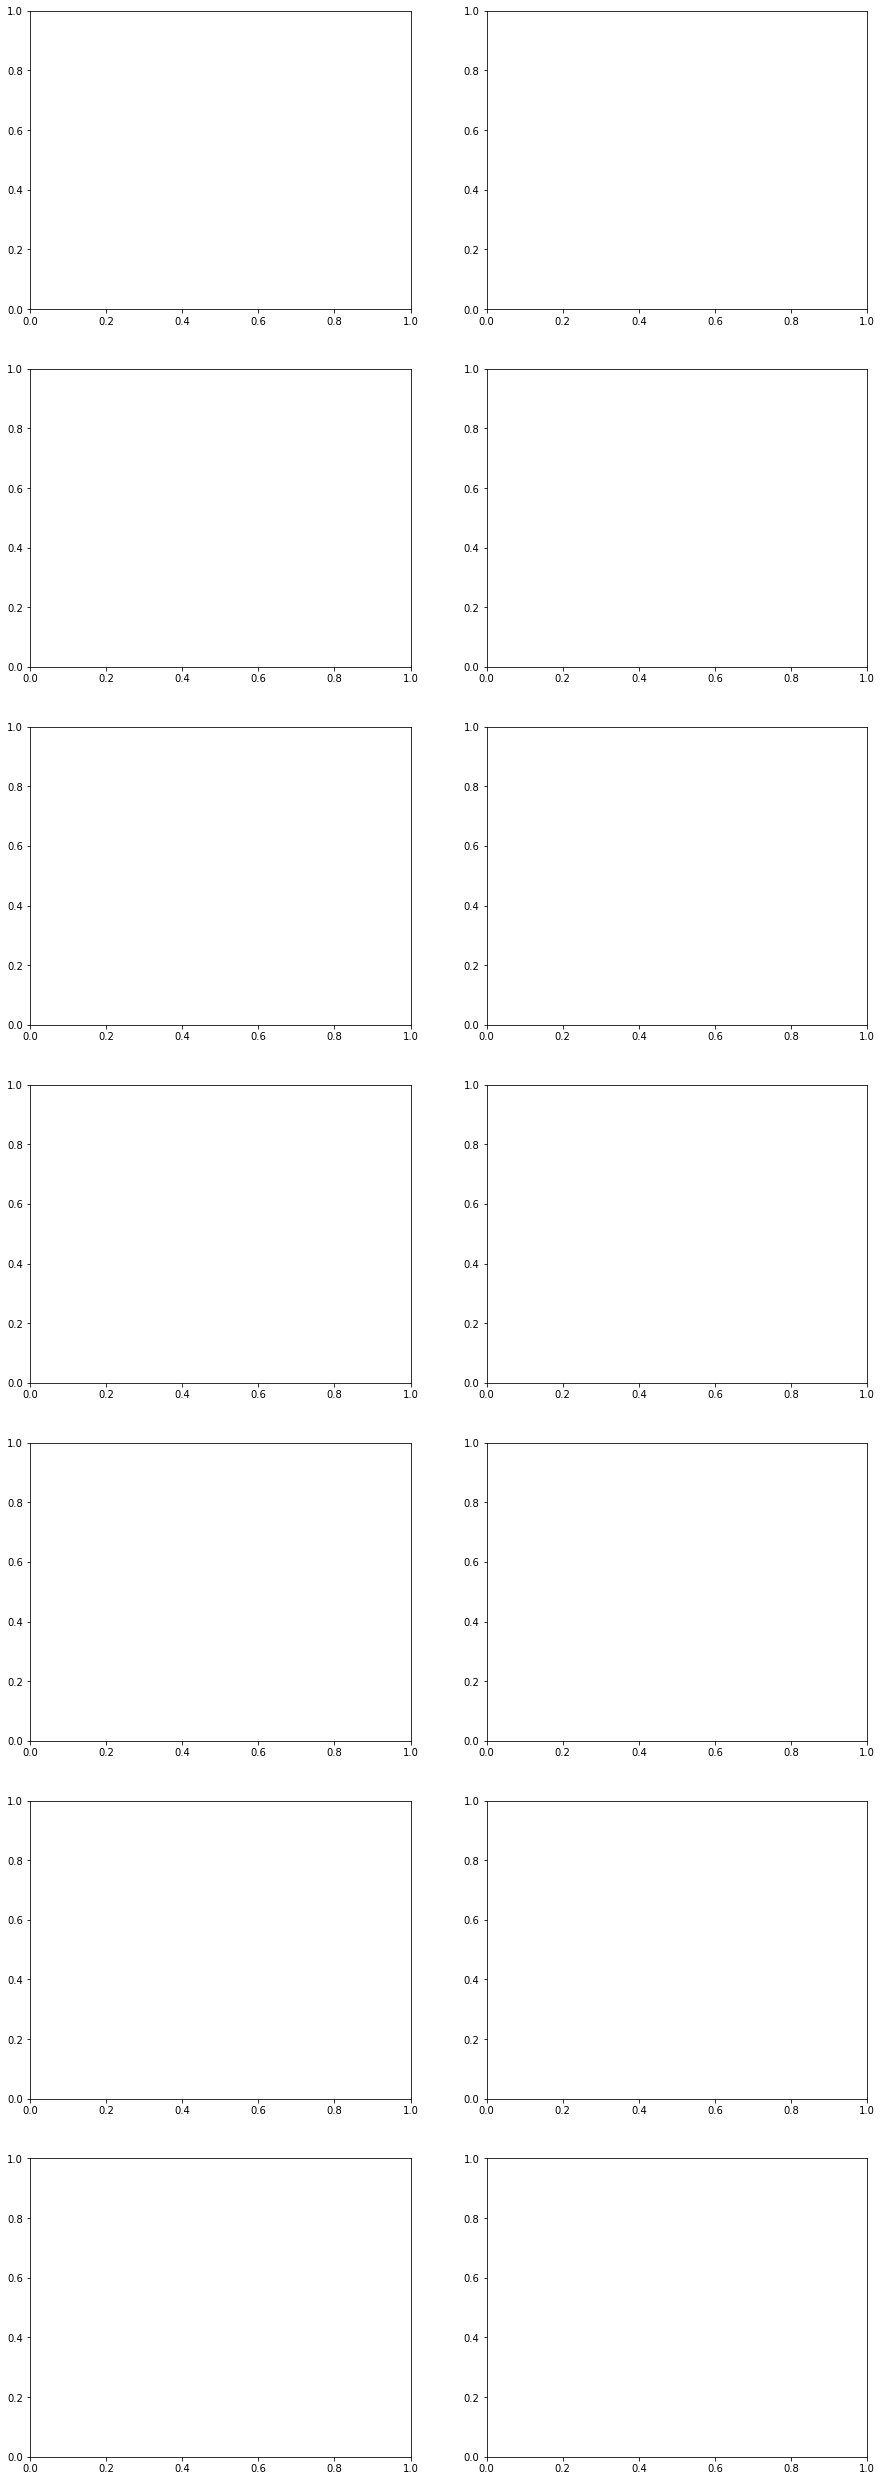

In [32]:
from scipy.stats import zscore


z_score_clean_filt_nx_rna_cell_df = filt_nx_rna_cell_df.groupby(filt_nx_rna_cell_df.index).first().apply(zscore,axis=1).loc[clean_genes_from_B_index].dropna(how="all")
z_score_clean_filt_intensity_profile = filt_intensity_profile.groupby(filt_intensity_profile.index).first().apply(zscore,axis=1).loc[clean_genes_from_B_index].dropna(how="all")

fig, axs = plt.subplots(7,2,figsize=(15,45))
for cell,ax in zip(z_score_clean_filt_intensity_profile.columns,axs.reshape(-1)) :
    x = z_score_clean_filt_nx_rna_cell_df[cell].dropna()
    y = z_score_clean_filt_intensity_profile[cell].dropna()
    
    x = x.groupby(x.index).first()
    y = y.groupby(y.index).first()
    
    mut_index = x.index.intersection(y.index)
#     print(mut_index)
    
    x = x[mut_index]
    y = y[mut_index]
    

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    ax.scatter(x, y, c=z,s=100, edgecolor='')
    ax.set_title(cell)
    ax.set_xlabel("Mrna zscore")
    ax.set_ylabel("massSpec zscore")
    ax.set_xlim([-2,4])
    ax.set_ylim([-2,4])

    rect_red = patches.Rectangle((2,2),2,2,linewidth=1,edgecolor='r',facecolor='none')
    rect_blue = patches.Rectangle((2,2),-4,2,linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect_red)
    ax.add_patch(rect_blue)
plt.subplots_adjust(hspace=0.5)  
    

In [ ]:
from scipy.stats import zscore


z_score_clean_filt_nx_rna_cell_df = filt_nx_rna_cell_df.groupby(filt_nx_rna_cell_df.index).first().apply(zscore,axis=1).loc[clean_genes_from_B_index].dropna(how="all").loc[mutual_genes_mass_mrna]
z_score_clean_filt_intensity_profile = filt_intensity_profile.groupby(filt_intensity_profile.index).first().apply(zscore,axis=1).loc[clean_genes_from_B_index].dropna(how="all").loc[mutual_genes_mass_mrna]

fig, axs = plt.subplots(7,2,figsize=(15,45))
for cell,ax in zip(z_score_clean_filt_intensity_profile.columns,axs.reshape(-1)) :
    x = z_score_clean_filt_nx_rna_cell_df[cell].dropna()
    y = z_score_clean_filt_intensity_profile[cell].dropna()
    
    x = x.groupby(x.index).first()
    y = y.groupby(y.index).first()
    
    mut_index = x.index.intersection(y.index)
#     print(mut_index)
    
    x = x[mut_index]
    y = y[mut_index]
    

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    ax.scatter(x, y, c=z,s=100, edgecolor='')
    ax.set_title(cell)
    ax.set_xlabel("Mrna zscore")
    ax.set_ylabel("massSpec zscore")
    ax.set_xlim([-2,4])
    ax.set_ylim([-2,4])

    rect_red = patches.Rectangle((2,2),2,2,linewidth=1,edgecolor='r',facecolor='none')
    rect_blue = patches.Rectangle((2,2),-4,2,linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect_red)
    ax.add_patch(rect_blue)
plt.subplots_adjust(hspace=0.5)  
    

In [ ]:
ax = plt.subplot()
ax.set_title("hist of correlation between Mrna and massSpec across genes")
filt_nx_rna_cell_df.corrwith(filt_intensity_profile,axis=1).hist(ax=ax)
plt.show()


# calculate proportions for stable genes with entropy signature

In [ ]:
# read ar mixtures data :  

In [ ]:
data_loader = DataLoader(mass_spec_path=os.path.abspath('../data/20150208_mixture_proteinGroups.xls'),
                         protein_profile_path = os.path.abspath('../data/20150718_Cerberus_proteinGroups.txt'))
data_factory = DataFactory(data_loader)
ar_mixtures,ar_mixtures_relvent_data = data_factory.build_mixture_data(intensity_type="Intensity")

B_ar = ar_mixtures.set_index("Majority protein IDs")[ar_mixtures_relvent_data]
B_ar=B_ar.rename({f:f.split('Intensity ')[1] for f in B_ar.columns},axis=1)


In [ ]:
cell_prop_exp = CellProportionsExperiments()

In [ ]:
mut =A_intensity.index.intersection(B_ar.index) 
_A = A_intensity.loc[mut][['Intensity NOT_CD4TCellTcm_01','Intensity NOT_BCellmemory_01','Intensity NOT_Monocytesnonclassical_01']]
_B = B_ar.loc[mut]

In [ ]:
from IPython.display import display, HTML

cmc = CellMixCoordinator()
def _calc_and_display_with_cellmix(_a,_b,X,with_cellMix = False,as_heatmap = False) : 
    if _a.empty :
        raise Exception("A is empty")
    if _b.empty :
        raise Exception("B is empty")
    
    cell_abundance_over_samples = CellProportions.fit_as_df(_a,_b)
    
    if with_cellMix : 
        cellMax_cell_abundance_over_samples = cmc.cell_prop_with_bash(_b,_a).rename({"Unnamed: 0":"cells"},axis=1).set_index("cells")
        if as_heatmap : 
            sns.heatmap(cellMax_cell_abundance_over_samples)
            plt.show()
        else :
            display(HTML(' <span style="color:blue"><h1>cellMix : </h1> </span>  '))
            display(cellMax_cell_abundance_over_samples)
    
    if as_heatmap : 
        sns.heatmap(cell_abundance_over_samples)
    else : 
        display(HTML(' <span style="color:blue"><h1>model : </h1> </span>  '))
        display(cell_abundance_over_samples)
        display(HTML(' <span style="color:blue"><h1>known cell proportion : </h1> </span>  '))
        display(X)
_calc_and_display_with_cellmix(_A,_B,True,True)